# House Price Prediction

##### LOAD THE FEATURE DATA

In [1]:
import pandas as pd
import numpy as np

X = pd.read_csv('../../../data/preprocessed_data/X.csv', sep=',')

print ('Feature data, shape:\nX: {}'.format(X.shape))
X.head()

Feature data, shape:
X: (506, 13)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


In [2]:
y = pd.read_csv('../../../data/preprocessed_data/y.csv', sep=',', header=None)

print ('Target data, shape:\ny: {}'.format(y.shape))
y.head()

Target data, shape:
y: (506, 1)


,0
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


##### SPLIT THE DATA

In [3]:
from sklearn.model_selection import train_test_split

# set the seed for reproducibility
np.random.seed(127)

# split the dataset into 2 training and 2 testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=13)

print('Data shapes:\n')
print('X_train : {}\ny_train : {}\n\nX_test : {}\ny_test : {}'.format(X_train.shape,
                                                                    y_train.shape,
                                                                    X_test.shape,
                                                                    y_test.shape))

Data shapes:

X_train : (404, 13)
y_train : (404, 1)

X_test : (102, 13)
y_test : (102, 1)


##### DEFINE NETWORK PARAMETERS

In [4]:
# define number of attributes
n_features = X_train.shape[1]
n_target = 1  # quantitative data

# count number of samples in each set of data
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# define amount of neurons
n_layer_in = n_features # 12 neurons in input layer
n_layer_h1 = 5          # first  hidden layer
n_layer_h2 = 5          # second hidden layer
n_layer_out = n_target  # 1 neurons in output layer

sigma_init = 0.01   # For randomized initialization

##### RESET TENSORFLOW GRAPH IF THERE IS ANY

In [5]:
import tensorflow as tf

# this will set up a specific seed in order to control the output 
# and get more homogeneous results though every model variation
def reset_graph(seed=127):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()

##### MODEL ARCHITECTURE

In [6]:
# create symbolic variables
X = tf.placeholder(tf.float32, [None, n_layer_in], name="input")
Y = tf.placeholder(tf.float32, [None, n_layer_out], name="output")

# deploy the variables that will store the weights
W = {
    'W1': tf.Variable(tf.random_normal([n_layer_in, n_layer_h1], stddev = sigma_init), name='W1'),
    'W2': tf.Variable(tf.random_normal([n_layer_h1, n_layer_h2], stddev = sigma_init), name='W2'),
    'W3': tf.Variable(tf.random_normal([n_layer_h2, n_layer_out], stddev = sigma_init), name='W3')
}

# deploy the variables that will store the bias
b = {
    'b1': tf.Variable(tf.random_normal([n_layer_h1]), name='b1'),
    'b2': tf.Variable(tf.random_normal([n_layer_h2]), name='b2'),
    'b3': tf.Variable(tf.random_normal([n_layer_out]), name='b3')
}

# this will create the model architecture and output the result
def model_MLP(_X, _W, _b):
    with tf.name_scope('hidden_1'):
        layer_h1 = tf.nn.selu(tf.add(tf.matmul(_X,_W['W1']), _b['b1']))
    with tf.name_scope('hidden_2'):
        layer_h2 = tf.nn.selu(tf.add(tf.matmul(layer_h1,_W['W2']), _b['b2']))
    with tf.name_scope('layer_output'):
        layer_out = tf.add(tf.matmul(layer_h2,_W['W3']), _b['b3'])
        return layer_out   # these are the predictions

with tf.name_scope("MLP"):
    y_pred = model_MLP(X, W, b)

##### DEFINE LEARNING RATE

In [7]:
learning_rate = 0.4

# CHOOSE A DECAYING METHOD IN HERE
model_decay = 'none'      # [exponential | inverse_time | natural_exponential | polynomial | none]

global_step = tf.Variable(0, trainable=False)
decay_rate = 0.90
decay_step = 10000

if model_decay == 'exponential':
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

elif model_decay == 'inverse_time':
    learning_rate = tf.train.inverse_time_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'natural_exponential':
    learning_rate = tf.train.natural_exp_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'polynomial':
    end_learning_rate = 0.001
    learning_rate = tf.train.polynomial_decay(learning_rate, global_step, decay_step, end_learning_rate, power=0.5)
    
else:
    decay_rate = 1.0
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

print('Decaying Learning Rate : ', model_decay)

Decaying Learning Rate :  none


##### DEFINE MODEL TRAINING AND MEASURE PERFORMANCE

In [8]:
with tf.name_scope("loss"):
    loss = tf.square(Y - y_pred)                                                       # squared error
    #loss = tf.nn.softmax(logits=y_pred)                                                # softmax
    #loss = tf.nn.log_softmax(logits=y_pred)                                            # log-softmax
    #loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=y_pred, dim=-1) # cross-entropy
    #loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=y_pred)            # sigmoid-cross-entropy
    #loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=y_pred)     # sparse-softmax-cross-entropy
    loss = tf.reduce_mean(loss, name='MSE')
    
with tf.name_scope("train"):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)                     # SGD
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9) # MOMENTUM
    #optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)               # ADAGRAD
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)              # ADADELTA
    #optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=1)      # RMS
    training_op = optimizer.minimize(loss, global_step=global_step)

# Create summaries    
tf.summary.scalar("loss", loss)
tf.summary.scalar("learn_rate", learning_rate)

# Merge all summaries into a single op to generate the summary data
merged_summary_op = tf.summary.merge_all()

##### EXECUTE THE MODEL

In [9]:
from datetime import datetime

# define some parameters
n_epochs = 40
display_epoch = 2   # checkpoint will also be created based on this
batch_size = 10
n_batches = int(n_train/batch_size)

# set up the directory to store the results for tensorboard
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

# this will help to restore the model to a specific epoch
saver = tf.train.Saver(tf.global_variables())

# store the results through every epoch iteration
mse_train_list = []
mse_test_list = []
learning_list = []
prediction_results = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # write logs for tensorboard
    summary_writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())
    
    for epoch in range(n_epochs):
        for i in range(0, n_train, batch_size):
            # create batches
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # improve the model
            _, _summary = sess.run([training_op, merged_summary_op], feed_dict={X:X_batch, Y:y_batch})
            
            # Write logs at every iteration
            summary_writer.add_summary(_summary, epoch * n_batches + i)

        # measure performance and display the results
        if (epoch+1) % display_epoch == 0:
            _mse_train = sess.run(loss, feed_dict={X: X_train, Y: y_train})
            _mse_test = sess.run(loss, feed_dict={X: X_test, Y: y_test})
            mse_train_list.append(_mse_train); mse_test_list.append(_mse_test)
            learning_list.append(sess.run(learning_rate))
            
            # Save model weights to disk for reproducibility
            saver = tf.train.Saver(max_to_keep=15)
            saver.save(sess, "tf_checkpoints/epoch{:04}.ckpt".format((epoch+1)))
            
            print("Epoch: {:04}\tTrainMSE: {:06.5f}\tTestMSE: {:06.5f}, Learning: {:06.7f}".format((epoch+1),
                                                                                                   _mse_train,
                                                                                                   _mse_test,
                                                                                                   learning_list[-1]))
    # store the predictuve values
    prediction_results = sess.run(y_pred, feed_dict={X: X_test, Y: y_test})
    predictions = sess.run(y_pred, feed_dict={X: X_test, Y: y_test})
    
    # output comparative table
    dataframe = pd.DataFrame(predictions, columns=['Prediction'])
    dataframe['Target'] = y_test
    dataframe['Difference'] = dataframe.Target - dataframe.Prediction
    print('\nPrinting results :\n\n', dataframe)
    


Epoch: 0002	TrainMSE: 596.19885	TestMSE: 545.42310, Learning: 0.4000000
Epoch: 0004	TrainMSE: 583.20251	TestMSE: 533.55811, Learning: 0.4000000
Epoch: 0006	TrainMSE: 35.75017	TestMSE: 34.80634, Learning: 0.4000000
Epoch: 0008	TrainMSE: 23.05773	TestMSE: 22.79489, Learning: 0.4000000
Epoch: 0010	TrainMSE: 21.23712	TestMSE: 20.91974, Learning: 0.4000000
Epoch: 0012	TrainMSE: 20.45389	TestMSE: 19.68934, Learning: 0.4000000
Epoch: 0014	TrainMSE: 19.87004	TestMSE: 18.63902, Learning: 0.4000000
Epoch: 0016	TrainMSE: 19.40698	TestMSE: 17.78506, Learning: 0.4000000
Epoch: 0018	TrainMSE: 19.03131	TestMSE: 17.12411, Learning: 0.4000000
Epoch: 0020	TrainMSE: 18.72885	TestMSE: 16.63563, Learning: 0.4000000
Epoch: 0022	TrainMSE: 18.51796	TestMSE: 16.38017, Learning: 0.4000000
Epoch: 0024	TrainMSE: 18.35551	TestMSE: 16.17319, Learning: 0.4000000
Epoch: 0026	TrainMSE: 18.25398	TestMSE: 16.04083, Learning: 0.4000000
Epoch: 0028	TrainMSE: 18.16143	TestMSE: 15.96518, Learning: 0.4000000
Epoch: 0030	Trai

##### VISUALIZE THE MODEL'S IMPROVEMENTS

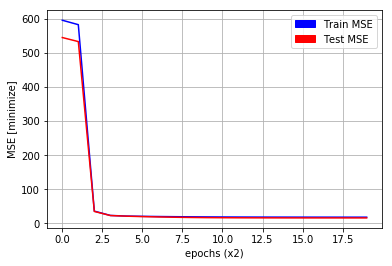

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set up legend
blue_patch = mpatches.Patch(color='blue', label='Train MSE')
red_patch = mpatches.Patch(color='red', label='Test MSE')
plt.legend(handles=[blue_patch,red_patch])
plt.grid()

# plot the data
plt.plot(mse_train_list, color='blue')
plt.plot(mse_test_list, color='red')

plt.xlabel('epochs (x{})'.format(display_epoch))
plt.ylabel('MSE [minimize]');

##### LEARNING RATE EVOLUTION

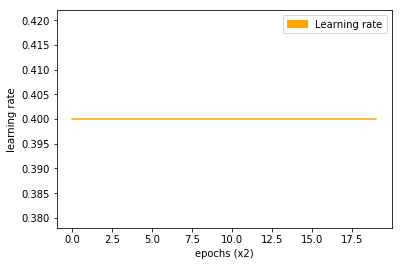

In [11]:
or_patch = mpatches.Patch(color='orange', label='Learning rate')
plt.legend(handles=[or_patch])

plt.plot(learning_list, color='orange');
plt.xlabel('epochs (x{})'.format(display_epoch))
plt.ylabel('learning rate');

##### VISUALIZE THE RESULTS

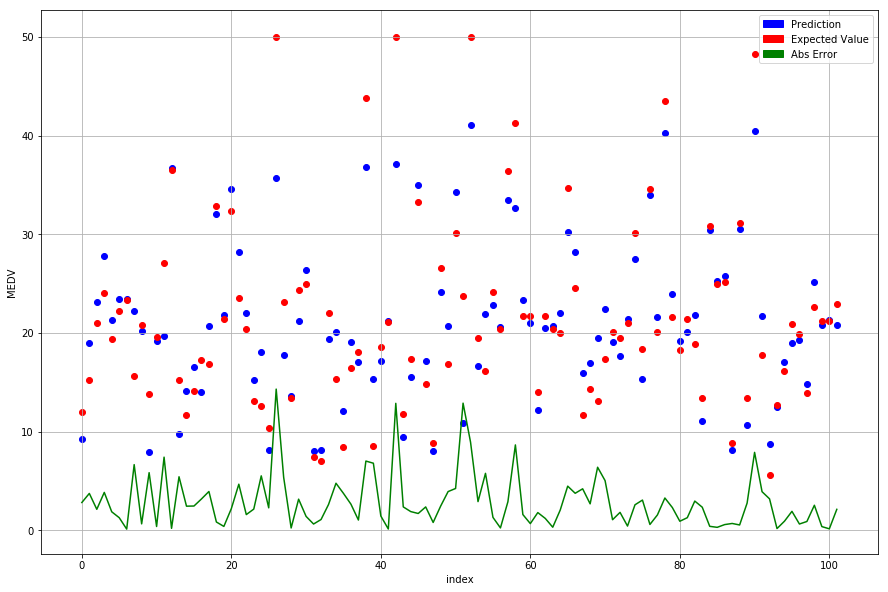

In [12]:
plt.figure(figsize=(15,10))

# define legend
blue_patch = mpatches.Patch(color='blue', label='Prediction')
red_patch = mpatches.Patch(color='red', label='Expected Value')
green_patch = mpatches.Patch(color='green', label='Abs Error')
plt.legend(handles=[blue_patch,red_patch, green_patch])

# plot data
x_array = np.arange(len(prediction_results))
plt.scatter(x_array, prediction_results, color='blue')
plt.scatter(x_array, y_test, color='red')

abs_error = abs(y_test-prediction_results)
plt.plot(x_array, abs_error, color='green')
plt.grid()

# define legends
plt.xlabel('index'.format(display_epoch))
plt.ylabel('MEDV');

##### VISUALIZE TENSORBOARD

In [13]:
'''
from IPython.display import clear_output, Image, display, HTML

#   CHECK IT ON TENSORBOARD TYPING THESE LINES IN THE COMMAND PROMPT:
#   tensorboard --logdir=/tmp/tf_logs

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
show_graph(tf.get_default_graph())
'''

'\nfrom IPython.display import clear_output, Image, display, HTML\n\n#   CHECK IT ON TENSORBOARD TYPING THESE LINES IN THE COMMAND PROMPT:\n#   tensorboard --logdir=/tmp/tf_logs\n\ndef strip_consts(graph_def, max_const_size=32):\n    """Strip large constant values from graph_def."""\n    strip_def = tf.GraphDef()\n    for n0 in graph_def.node:\n        n = strip_def.node.add() \n        n.MergeFrom(n0)\n        if n.op == \'Const\':\n            tensor = n.attr[\'value\'].tensor\n            size = len(tensor.tensor_content)\n            if size > max_const_size:\n                tensor.tensor_content = b"<stripped %d bytes>"%size\n    return strip_def\n\ndef show_graph(graph_def, max_const_size=32):\n    """Visualize TensorFlow graph."""\n    if hasattr(graph_def, \'as_graph_def\'):\n        graph_def = graph_def.as_graph_def()\n    strip_def = strip_consts(graph_def, max_const_size=max_const_size)\n    code = """\n        <script>\n          function load() {{\n            document.g

##### RESTORE TO CHECKPOINT

In [14]:
'''
# select the epoch to be restored
epoch = 50

# Running a new session
print('Restoring model to Epoch {}\n'.format(epoch))


with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Restore model weights from previously saved model
    checkpoint = tf.train.import_meta_graph('tf_checkpoints/epoch{:04}.ckpt.meta'.format(epoch))
    #checkpoint.restore(sess, 'tf_checkpoints/epoch{:04}'.format(epoch))
    
    # store the predictuve values
    predictions = sess.run(y_pred, feed_dict={X: X_test, Y: y_test})
    
    # output comparative table
    dataframe = pd.DataFrame(predictions, columns=['Prediction'])
    dataframe['Target'] = y_test
    dataframe['Difference'] = dataframe.Target - dataframe.Prediction

dataframe
'''

"\n# select the epoch to be restored\nepoch = 50\n\n# Running a new session\nprint('Restoring model to Epoch {}\n'.format(epoch))\n\n\nwith tf.Session() as sess:\n    # Initialize variables\n    sess.run(tf.global_variables_initializer())\n    \n    # Restore model weights from previously saved model\n    checkpoint = tf.train.import_meta_graph('tf_checkpoints/epoch{:04}.ckpt.meta'.format(epoch))\n    #checkpoint.restore(sess, 'tf_checkpoints/epoch{:04}'.format(epoch))\n    \n    # store the predictuve values\n    predictions = sess.run(y_pred, feed_dict={X: X_test, Y: y_test})\n    \n    # output comparative table\n    dataframe = pd.DataFrame(predictions, columns=['Prediction'])\n    dataframe['Target'] = y_test\n    dataframe['Difference'] = dataframe.Target - dataframe.Prediction\n\ndataframe\n"